# Importing libraries and dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from pathlib import Path

# Base folder that contains the Citi Bike CSVs (recursive search)
raw_path = Path(r"C:\Users\User\Downloads\Citibike-Weather-Dashboard\Data\Raw\citibike-2022")

# Find all trip CSVs under Raw (e.g., Raw\citibike-2022\*.csv)
trip_files = list(raw_path.rglob("*.csv"))
print("CSV files found:", len(trip_files))

if not trip_files:
    raise FileNotFoundError(f"No CSV files found under: {raw_path}")

# Read + concatenate
citibike_df = pd.concat((pd.read_csv(f) for f in trip_files), ignore_index=True)

# Convert to datetime and extract date
citibike_df['started_at'] = pd.to_datetime(citibike_df['started_at'])
citibike_df['date'] = citibike_df['started_at'].dt.date


CSV files found: 12


In [4]:
import pandas as pd
import json

with open(
    r"C:\Users\User\Downloads\Citibike-Weather-Dashboard\Data\Processed\weather_2022.json",
    "r"
) as f:
    weather_data = json.load(f)

# weather_data IS already a list of records
weather_raw_df = pd.DataFrame(weather_data)

print(weather_raw_df.head())

                  date datatype            station attributes    value
0  2022-01-01T00:00:00     ADPT  GHCND:USW00014732       ,,W,    100.0
1  2022-01-01T00:00:00     ASLP  GHCND:USW00014732       ,,W,  10078.0
2  2022-01-01T00:00:00     ASTP  GHCND:USW00014732       ,,W,  10078.0
3  2022-01-01T00:00:00     AWBT  GHCND:USW00014732       ,,W,    106.0
4  2022-01-01T00:00:00     AWND  GHCND:USW00014732       ,,W,      2.8


In [5]:
weather_raw_df["date"] = pd.to_datetime(weather_raw_df["date"])
weather_raw_df["day"] = weather_raw_df["date"].dt.date  # daily join key

In [6]:
weather_daily_wide = (
    weather_raw_df
    .pivot_table(
        index="day",
        columns="datatype",
        values="value",
        aggfunc="mean"   # safe default if duplicates exist
    )
    .reset_index()
)

weather_daily_wide.columns.name = None
weather_daily_wide.head()

,day,ADPT,ASLP,ASTP,AWBT,AWND,PRCP,RHAV,RHMN,RHMX,...,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
0,2022-01-01,100.0,10078.0,10078.0,106.0,2.8,19.3,89.0,83.0,93.0,...,200.0,6.3,7.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,67.0,10051.0,10024.0,83.0,4.3,1.0,80.0,63.0,93.0,...,310.0,12.5,14.8,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,-100.0,10196.0,10169.0,-39.0,6.4,0.0,49.0,38.0,62.0,...,350.0,12.5,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,-117.0,10281.0,10268.0,-44.0,3.9,0.0,48.0,35.0,60.0,...,350.0,8.9,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05,6.0,10132.0,10139.0,33.0,3.4,6.1,76.0,52.0,86.0,...,200.0,6.7,10.7,1.0,NaN,NaN,NaN,NaN,1.0,NaN


In [7]:
for c in ["TMAX", "TMIN", "TAVG"]:
    if c in weather_daily_wide.columns:
        weather_daily_wide[c] = weather_daily_wide[c] / 10.0  # tenths of °C to °C

In [8]:
keep = [c for c in ["day", "TAVG", "TMAX", "TMIN", "PRCP", "AWND"] if c in weather_daily_wide.columns]
weather_daily = weather_daily_wide[keep].copy()
weather_daily.head()

,day,TAVG,TMAX,TMIN,PRCP,AWND
0,2022-01-01,1.16,1.39,1.00,19.3,2.8
1,2022-01-02,1.14,1.56,0.39,1.0,4.3
2,2022-01-03,0.14,0.39,-0.43,0.0,6.4
3,2022-01-04,-0.27,0.22,-0.60,0.0,3.9
4,2022-01-05,0.32,0.89,0.00,6.1,3.4


In [9]:
citibike_df["started_at"] = pd.to_datetime(citibike_df["started_at"])
citibike_df["day"] = citibike_df["started_at"].dt.date

citibike_weather_df = citibike_df.merge(weather_daily, on="day", how="left")

In [10]:
weather_raw_df["datatype"].value_counts().head(20)

datatype
TMAX    365
WDF2    365
WSF5    365
WSF2    365
AWND    365
PRCP    365
SNOW    365
SNWD    365
TAVG    365
WDF5    365
TMIN    365
RHAV    364
RHMN    364
RHMX    364
ADPT    363
ASLP    363
AWBT    363
ASTP    363
WT01     91
WT08     46
Name: count, dtype: int64

In [11]:
import pandas as pd
import json

with open(
    r"C:\Users\User\Downloads\Citibike-Weather-Dashboard\Data\Processed\weather_2022.json",
    "r"
) as f:
    weather_data = json.load(f)

# weather_data is already a list of records
weather_raw_df = pd.DataFrame(weather_data)

# Convert date to daily key
weather_raw_df["date"] = pd.to_datetime(weather_raw_df["date"]).dt.date

# Pivot to wide daily format
weather_df = (
    weather_raw_df
    .pivot_table(
        index="date",
        columns="datatype",
        values="value",
        aggfunc="mean"
    )
    .reset_index()
)

# Optional renaming
weather_df.rename(columns={
    "TMAX": "max_temp",
    "TMIN": "min_temp",
    "PRCP": "precip"
}, inplace=True)

In [12]:
# Merge trips with weather by date
merged_df = citibike_df.merge(weather_df, on='date', how='left')

In [13]:
merged_df.to_csv("citibike_weather_2022.csv", index=False)
print("File saved ✅")

File saved ✅


In [14]:
df = pd.read_csv("citibike_weather_2022.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
0,CA5837152804D4B5,electric_bike,2022-01-26 18:50:39,2022-01-26 18:51:53,12 St & Sinatra Dr N,HB201,12 St & Sinatra Dr N,HB201,40.750604,-74.024020,...,320.0,10.7,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BA06A5E45B6601D2,classic_bike,2022-01-28 13:14:07,2022-01-28 13:20:23,Essex Light Rail,JC038,Essex Light Rail,JC038,40.712774,-74.036486,...,30.0,8.1,11.2,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,7B6827D7B9508D93,classic_bike,2022-01-10 19:55:13,2022-01-10 20:00:37,Essex Light Rail,JC038,Essex Light Rail,JC038,40.712774,-74.036486,...,320.0,11.6,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6E5864EA6FCEC90D,electric_bike,2022-01-26 07:54:57,2022-01-26 07:55:22,12 St & Sinatra Dr N,HB201,12 St & Sinatra Dr N,HB201,40.750604,-74.024020,...,320.0,10.7,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E24954255BBDE32D,electric_bike,2022-01-13 18:44:46,2022-01-13 18:45:43,12 St & Sinatra Dr N,HB201,12 St & Sinatra Dr N,HB201,40.750604,-74.024020,...,60.0,5.8,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Read Data for Visualization

In [15]:
df = pd.read_csv("citibike_weather_2022.csv")
df['date'] = pd.to_datetime(df['date'])

# Line Plot – Max Temperature Over Time

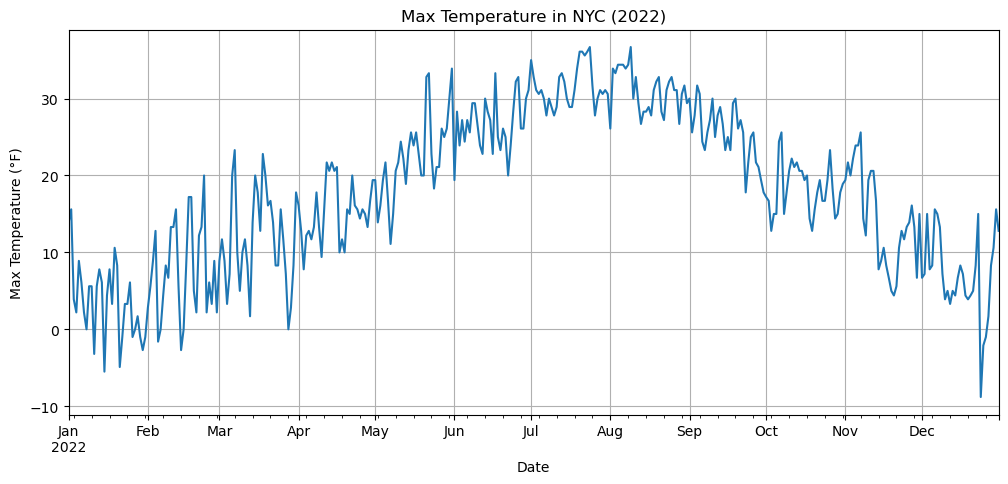

In [16]:
df.groupby('date')['max_temp'].mean().plot(figsize=(12,5), title='Max Temperature in NYC (2022)')
plt.xlabel("Date")
plt.ylabel("Max Temperature (°F)")
plt.grid(True)
plt.show()

# Add Trip Count Per Day and Merge

In [21]:
daily = (
    df.groupby("date")
      .size()
      .reset_index(name="trip_count")
)

In [22]:
daily_weather = (
    df.groupby("date", as_index=False)
      .agg(
          trip_count=("ride_id", "count"),
          temperature=("TAVG", "mean")
      )
)

In [23]:
daily_weather = daily_weather.sort_values("date")

In [29]:
# Merge back into the DataFrame
df_daily = df.drop_duplicates(subset='date', keep='first')  # avoid duplicate merge
df_daily = df_daily.merge(trip_counts, on='date')

# Dual-Axis Line Chart – Trips vs. Temperature

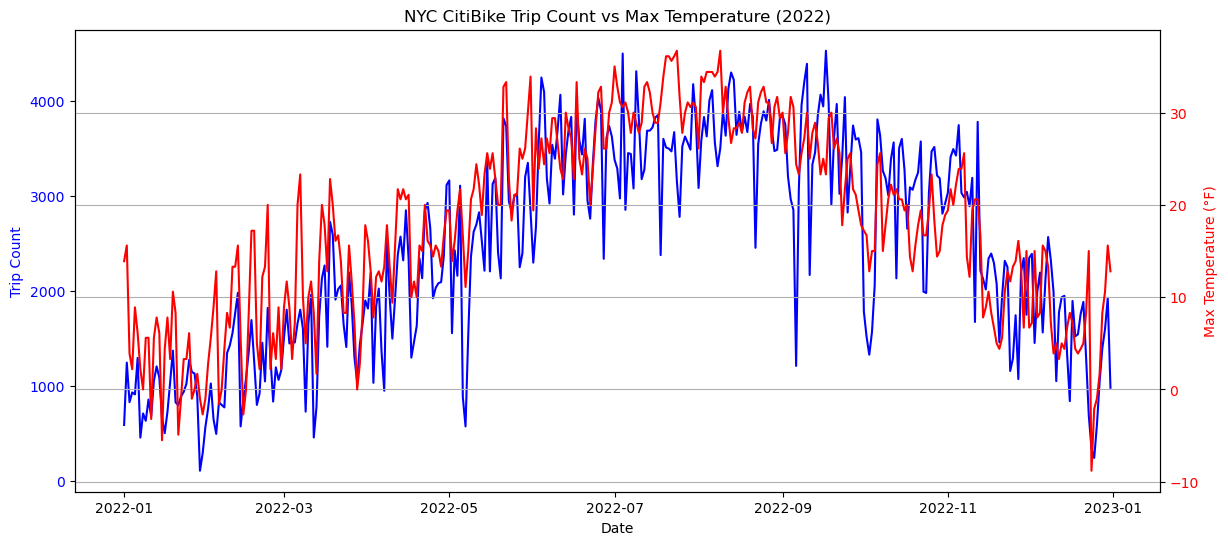

In [30]:
fig, ax1 = plt.subplots(figsize=(14,6))

# Plot trip count
ax1.plot(df_daily['date'], df_daily['trip_count'], color='blue', label='Trip Count')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trip Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot temperature on secondary axis
ax2 = ax1.twinx()
ax2.plot(df_daily['date'], df_daily['max_temp'], color='red', label='Max Temp')
ax2.set_ylabel('Max Temperature (°F)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('NYC CitiBike Trip Count vs Max Temperature (2022)')
plt.grid(True)
plt.show()


## Explanation

In this notebook, I used Matplotlib and Pandas to analyze CitiBike usage in NYC and its relationship with daily weather in 2022.

- First, I recreated and saved a cleaned, merged dataset of CitiBike trips and NOAA weather data.
- I used Pandas' `.plot()` method (a wrapper over Matplotlib) for quick visualizations.
- For the dual-axis chart, I used Matplotlib's **object-oriented API**, creating `ax1` and `ax2` to plot trip counts and temperatures on separate Y-axes.

This allowed me to visualize how ridership correlates with changes in temperature over time.
